# 📊 Real-time Bitcoin Sentiment Analysis and Price Prediction with `llm`

This project builds an end-to-end pipeline to:
- Ingest real-time Bitcoin-related text data (News, Twitter, Reddit)
- Uses NewsAPI to extract all the news articles
- Perform sentiment analysis and topic modeling using LLMs (via the `llm` library)
- Aggregate results into a sentiment time series
- Predict future Bitcoin prices using models like Linear Regression, LSTM, and Prophet
- Visualize trends and deploy a real-time dashboard using Streamlit

---

### 🔧 Technologies Used
- `llm`: Simple Python wrapper for interacting with Large Language Models
- `NewsAPI`: For data ingestion
- `OpenAI` (via `llm`): For sentiment analysis and topic modeling
- `CoinGecko API`: For Bitcoin price data
- `Pandas`, `Seaborn`, `Matplotlib`: For analysis and visualization
- `scikit-learn`, `Prophet`, `LSTM`: For price prediction
- `Streamlit`: For dashboard visualization


### Installing the libraries

In [2]:
# Install dotenv if not already
!pip install python-dotenv


Defaulting to user installation because normal site-packages is not writeable


### Load variables and API keys from environment

In [3]:
import os
from dotenv import load_dotenv

# Load environment variables from .env
load_dotenv()

# Access keys from environment
NEWS_API_KEY = os.getenv("NEWS_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")


In [4]:
# Setup and Imports
# 📦 Install required packages
# Uncomment if running for the first time
!pip install llm openai requests pandas matplotlib seaborn scikit-learn wordcloud prophet

# 📚 Imports
import os
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# ⚙️ Model & NLP
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from wordcloud import WordCloud

# 📊 Plot settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ All libraries loaded and ready!")


Defaulting to user installation because normal site-packages is not writeable
✅ All libraries loaded and ready!


# Fetch Bitcoin News from NewsAPI

### Fetch Bitcoin news from NewsAPI and save to JSON

We fetch 100 articles each from one page, as the free API allows only 100 news articles per page

Various keywords are used like "Bitcoin", "BTC", " Bitcoin regulation", etc

#### Combining all the 100*10 news articles into one .json file and removing Duplicates

In [9]:
# remove duplicates from the combined files

In [10]:
import requests
import json
from datetime import datetime, date, timedelta
from pathlib import Path

def fetch_multi_keyword_bitcoin_news(
    keywords,
    save_dir="news_data",
    page_size=100,
    from_date=None,
    to_date=None
):
    output_path = Path(save_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    all_articles = []

    print("Starting multi-keyword news fetch...")
    
    for keyword in keywords:
        params = {
            "q": keyword,
            "sortBy": "publishedAt",
            "language": "en",
            "pageSize": page_size,
            "page": 1,
            "apiKey": NEWS_API_KEY
        }
        if from_date:
            params["from"] = from_date
        if to_date:
            params["to"] = to_date

        try:
            response = requests.get("https://newsapi.org/v2/everything", params=params)
            response.raise_for_status()
            articles = response.json().get("articles", [])
            print(f"✅ Fetched {len(articles)} articles for keyword: {keyword}")
        except requests.exceptions.RequestException as e:
            print(f"❌ Error fetching {keyword}: {e}")
            articles = []

        for article in articles:
            all_articles.append({
                "title": article.get("title"),
                "description": article.get("description"),
                "publishedAt": article.get("publishedAt"),
                "source": article.get("source", {}).get("name"),
                "url": article.get("url")
            })

    # Deduplicate by title + publishedAt
    unique_articles = {
        f"{item['title']}|{item['publishedAt']}": item
        for item in all_articles
    }.values()

    # Save to file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = output_path / f"bitcoin_news_final_{timestamp}.json"
    with open(filename, "w") as f:
        json.dump(list(unique_articles), f, indent=2)

    print(f"\n Combined total: {len(unique_articles)} unique articles saved to {filename}")
    return list(unique_articles)


In [11]:
from datetime import date, timedelta
import requests
import json
from datetime import datetime, date, timedelta
from pathlib import Path

keywords = [
    "Bitcoin", "BTC", "Bitcoin ETF", "Bitcoin crash",
    "crypto market", "blockchain adoption", "Bitcoin halving",
    "Bitcoin regulation", "Bitcoin price", "crypto investment"
]

from_date = (date.today() - timedelta(days=7)).isoformat()
to_date = date.today().isoformat()

all_news = fetch_multi_keyword_bitcoin_news(
    keywords=keywords,
    from_date=from_date,
    to_date=to_date
)

Starting multi-keyword news fetch...
✅ Fetched 99 articles for keyword: Bitcoin
✅ Fetched 100 articles for keyword: BTC
✅ Fetched 100 articles for keyword: Bitcoin ETF
✅ Fetched 74 articles for keyword: Bitcoin crash
✅ Fetched 100 articles for keyword: crypto market
✅ Fetched 100 articles for keyword: blockchain adoption
✅ Fetched 33 articles for keyword: Bitcoin halving
✅ Fetched 92 articles for keyword: Bitcoin regulation
✅ Fetched 100 articles for keyword: Bitcoin price
✅ Fetched 100 articles for keyword: crypto investment

 Combined total: 567 unique articles saved to news_data\bitcoin_news_final_20250517_150809.json


### Performing Sentiment Analysis on the file with 500+ articles

In [12]:
import os
from dotenv import load_dotenv
from openai import OpenAI

# 🔐 Load API key from .env file
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# 🧠 Sentiment Analysis Function
def analyze_sentiment_openai(text):
    prompt = f"Classify the sentiment of this Bitcoin-related news as Positive, Neutral, or Negative:\n\"{text}\""
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return response.choices[0].message.content.strip().split('\n')[0]
    except Exception as e:
        print(f"❌ OpenAI Error: {e}")
        return "Unknown"


#### Tagging sentiments as Neutral, Positive or Negative 

In [13]:
import json
import re
import os
from pathlib import Path
from datetime import datetime
from openai import OpenAI
from dotenv import load_dotenv

# ✅ Load API key from .env
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)

# Text cleaner
def clean_text(text):
    if not text:
        return ""
    text = re.sub(r"http\\S+|www\\S+|https\\S+", '', text)
    text = re.sub(r"[^A-Za-z0-9\\s]", '', text)
    text = re.sub(r"\\s+", ' ', text).strip()
    return text

# GPT-3.5 Sentiment Classifier
def analyze_sentiment_openai(text):
    prompt = f"Classify the sentiment of this Bitcoin-related news as Positive, Neutral, or Negative:\\n\\\"{text}\\\""
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return response.choices[0].message.content.strip().split('\\n')[0]
    except Exception as e:
        print(f"❌ OpenAI Error: {e}")
        return "Unknown"

# Load your news file
input_path = "news_data/bitcoin_news_final_20250516_003436.json"
with open(input_path, "r") as f:
    articles = json.load(f)

# Run classification
enriched_articles = []
for i, article in enumerate(articles):
    combined = f"{article.get('title', '')}. {article.get('description', '')}"
    cleaned = clean_text(combined)
    sentiment = analyze_sentiment_openai(cleaned)
    article["cleaned_text"] = cleaned
    article["sentiment"] = sentiment
    enriched_articles.append(article)
    print(f"✅ [{i+1}/{len(articles)}] Sentiment: {sentiment}")

# Save output
output_dir = Path("sentiment_data")
output_dir.mkdir(exist_ok=True)
output_file = output_dir / f"bitcoin_news_sentiment_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

with open(output_file, "w") as f:
    json.dump(enriched_articles, f, indent=2)

print(f"\\n✅ Saved sentiment-tagged news to: {output_file}")


✅ [1/541] Sentiment: Neutral
✅ [2/541] Sentiment: Positive
✅ [3/541] Sentiment: Neutral
✅ [4/541] Sentiment: Neutral
✅ [5/541] Sentiment: Neutral
✅ [6/541] Sentiment: Positive
✅ [7/541] Sentiment: Neutral
✅ [8/541] Sentiment: Neutral
✅ [9/541] Sentiment: Neutral
✅ [10/541] Sentiment: Negative
✅ [11/541] Sentiment: Neutral
✅ [12/541] Sentiment: Neutral
✅ [13/541] Sentiment: Neutral
✅ [14/541] Sentiment: Neutral
✅ [15/541] Sentiment: Neutral
✅ [16/541] Sentiment: Negative
✅ [17/541] Sentiment: Positive
✅ [18/541] Sentiment: Negative
✅ [19/541] Sentiment: Neutral
✅ [20/541] Sentiment: Neutral
✅ [21/541] Sentiment: Negative
✅ [22/541] Sentiment: Neutral
✅ [23/541] Sentiment: Neutral
✅ [24/541] Sentiment: Neutral
✅ [25/541] Sentiment: Neutral
✅ [26/541] Sentiment: Neutral
✅ [27/541] Sentiment: Neutral
✅ [28/541] Sentiment: Positive
✅ [29/541] Sentiment: Positive
✅ [30/541] Sentiment: Neutral
✅ [31/541] Sentiment: Neutral
✅ [32/541] Sentiment: Positive
✅ [33/541] Sentiment: Positive
✅ [34/54

#### Loading the sentiment analysis file and saving .csv files of sentiment counts and percent

In [14]:
import pandas as pd
import json
from pathlib import Path

# Load sentiment-tagged file
input_path = "sentiment_data/bitcoin_news_sentiment_20250516_032922.json"
with open(input_path, "r") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

#Convert publishedAt to date
df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')
df['date'] = df['publishedAt'].dt.date

#Count sentiment per day
sentiment_daily = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# Compute % sentiment
sentiment_percent = sentiment_daily.div(sentiment_daily.sum(axis=1), axis=0) * 100

# Save both versions
sentiment_daily.to_csv("sentiment_data/daily_sentiment_counts.csv")
sentiment_percent.to_csv("sentiment_data/daily_sentiment_percent.csv")

# Preview
print(" Sentiment Counts:")
print(sentiment_daily.head())
print("\n Sentiment Percentages:")
print(sentiment_percent.head())


 Sentiment Counts:
sentiment   Negative  Neutral  Positive
date                                   
2025-05-09         6       13         6
2025-05-10         4        6        10
2025-05-11         3       11        16
2025-05-12         3       18        32
2025-05-13         6       46        58

 Sentiment Percentages:
sentiment    Negative    Neutral   Positive
date                                       
2025-05-09  24.000000  52.000000  24.000000
2025-05-10  20.000000  30.000000  50.000000
2025-05-11  10.000000  36.666667  53.333333
2025-05-12   5.660377  33.962264  60.377358
2025-05-13   5.454545  41.818182  52.727273


# Fetch BTC price and mergeing with sentiment

In [15]:
import pandas as pd
import requests
from datetime import datetime
from pathlib import Path

# Load your daily sentiment percentage data
sentiment_df = pd.read_csv("sentiment_data/daily_sentiment_percent.csv")
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

#Fetch historical BTC prices from CoinGecko (last 30 days)
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {"vs_currency": "usd", "days": "30", "interval": "daily"}

response = requests.get(url, params=params)
data = response.json()

#Extract and clean price data
prices = data.get("prices", [])
btc_df = pd.DataFrame(prices, columns=["timestamp", "price"])
btc_df['date'] = pd.to_datetime(btc_df['timestamp'], unit='ms').dt.date
btc_df = btc_df.groupby('date').mean().reset_index()

#Merge with sentiment data
sentiment_df['date'] = sentiment_df['date'].dt.date
merged = pd.merge(sentiment_df, btc_df, on='date', how='inner')

#Save merged dataset
Path("merged_data").mkdir(exist_ok=True)
merged.to_csv("merged_data/sentiment_price_data.csv", index=False)

#Preview
print("✅ Merged dataset:")
print(merged.head())


✅ Merged dataset:
         date   Negative    Neutral   Positive     timestamp          price
0  2025-05-09  24.000000  52.000000  24.000000  1.746749e+12  103076.275555
1  2025-05-10  20.000000  30.000000  50.000000  1.746835e+12  102962.540457
2  2025-05-11  10.000000  36.666667  53.333333  1.746922e+12  104630.879299
3  2025-05-12   5.660377  33.962264  60.377358  1.747008e+12  103994.061617
4  2025-05-13   5.454545  41.818182  52.727273  1.747094e+12  102876.830429


###  Model the price using Linear Regression

✅ Mean Squared Error: 683529.53
✅ R² Score: -0.73


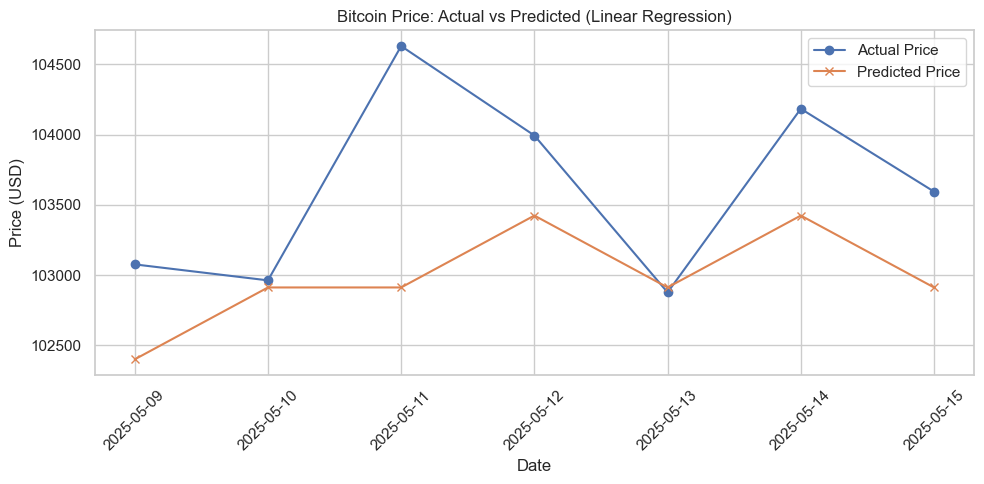

In [16]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load merged sentiment + price data
df = pd.read_csv("merged_data/sentiment_price_data.csv")

# Ensure all sentiment columns exist (in case any sentiment is missing in data)
for col in ['Positive', 'Neutral', 'Negative']:
    if col not in df.columns:
        df[col] = 0.0

#Features and target
X = df[['Positive', 'Neutral', 'Negative']]
y = df['price']

# Train model
model = LinearRegression()
model.fit(X, y)

# Predict
y_pred = model.predict(X)

# Evaluation
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"✅ Mean Squared Error: {mse:.2f}")
print(f"✅ R² Score: {r2:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(df['date'], y, label="Actual Price", marker='o')
plt.plot(df['date'], y_pred, label="Predicted Price", marker='x')
plt.xticks(rotation=45)
plt.title("Bitcoin Price: Actual vs Predicted (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Forecast Bitcoin Price Using Prophet

In [17]:
!pip install prophet


Defaulting to user installation because normal site-packages is not writeable


15:11:05 - cmdstanpy - INFO - Chain [1] start processing
15:11:05 - cmdstanpy - INFO - Chain [1] done processing


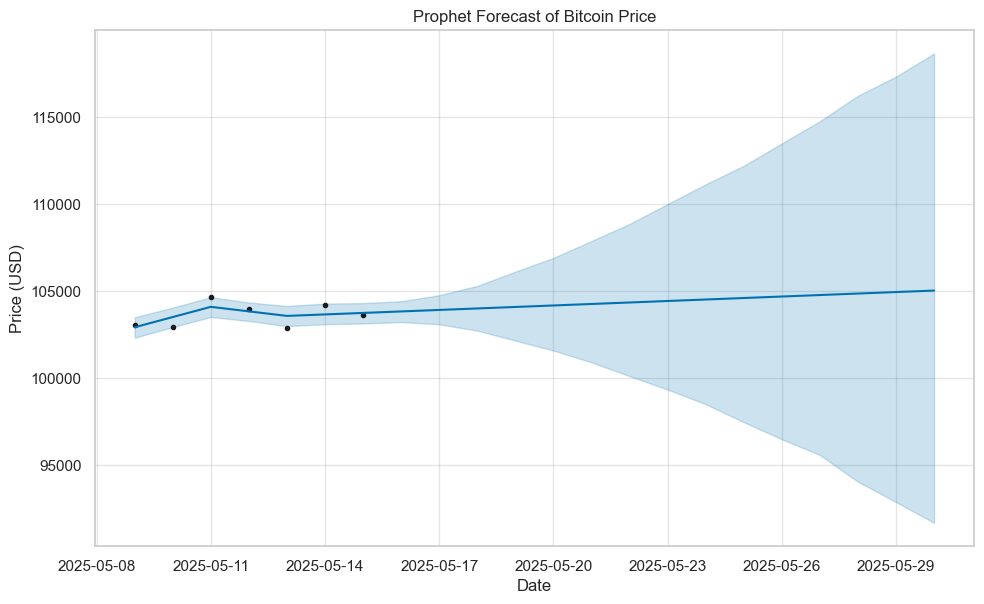

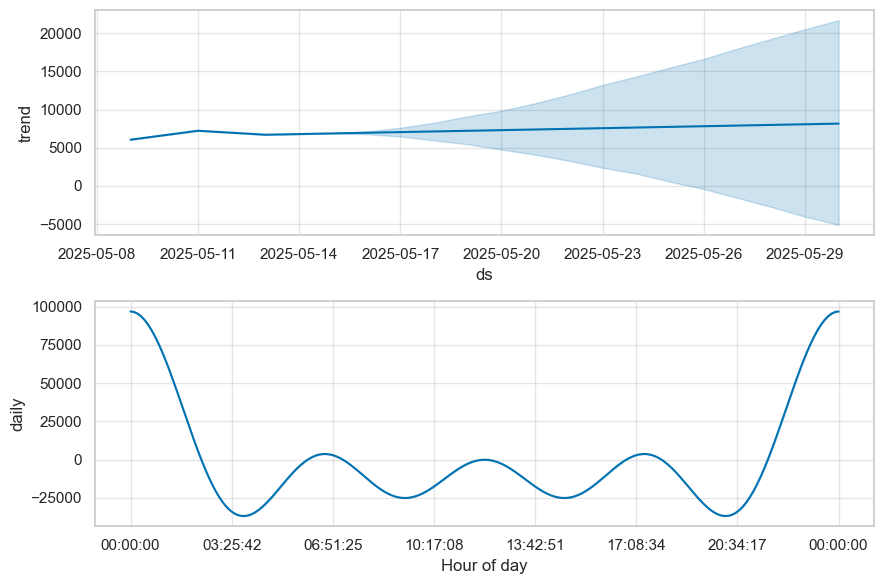

In [18]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

#Load merged data/
df = pd.read_csv("merged_data/sentiment_price_data.csv")

#Prophet requires 'ds' (date) and 'y' (value) columns
prophet_df = df[['date', 'price']].rename(columns={"date": "ds", "price": "y"})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

#Fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

# Create future dates (next 15 days)
future = model.make_future_dataframe(periods=15)

# Predict
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Prophet Forecast of Bitcoin Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

#Plot trend + seasonality components
fig2 = model.plot_components(forecast)
plt.show()


#### Plot Explainations:

1. Main Forecast Plot (Top Panel)

i) The Line: The blue line is Prophet’s forecasted average Bitcoin price day by day (e.g., $105,000 by May 20).

ii) The Black Dots: These are your actual BTC prices from past sentiment-enriched data.

iii) The Shaded Area: This is Prophet’s uncertainty interval (confidence bounds)

--> It tells you: “There’s a 95% chance the true price will lie within this band.”


📌 Insight: 

The model expects the price to remain stable (~$105k) for a few days

But the uncertainty grows as we forecast farther — which is typical

---

📈 2. Trend Plot (Middle Panel)

i) the underlying trend component Prophet learned

ii) Looks like the trend is relatively flat right now

iii) Slight dip in the near term (maybe from recent negative sentiment)

iv) Projected upward lift from May 20+

📌 Insight: 

Your historical data may not show a strong trend yet (only ~7-10 days)
    
But Prophet thinks price could grow if patterns repeat

---

🔁 3. Seasonality Plot (Bottom Panel)

i) This is daily seasonality, showing how price tends to vary by hour of the day

ii) X-axis is time of day

iii) Y-axis is effect on price (positive or negative)


📌 Insight: 

Prophet is detecting intraday cycles (price dips and peaks during the day)
            
Even though you fed it daily data, Prophet still builds default hourly seasonality — which you can turn off if it's misleading

---

#### CONCLUSION: 
✅ Prophet learned a mild upward trend and some seasonality

⚠️ The wide confidence bands mean: short time window, limited past data

This is great for exploration, but: (i) Not ideal for short-term trading, (ii)Doesn’t factor in sentiment directly

### LSTM

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,777 (77.25 KB)

 Trainable params: 19,777 (77.25 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


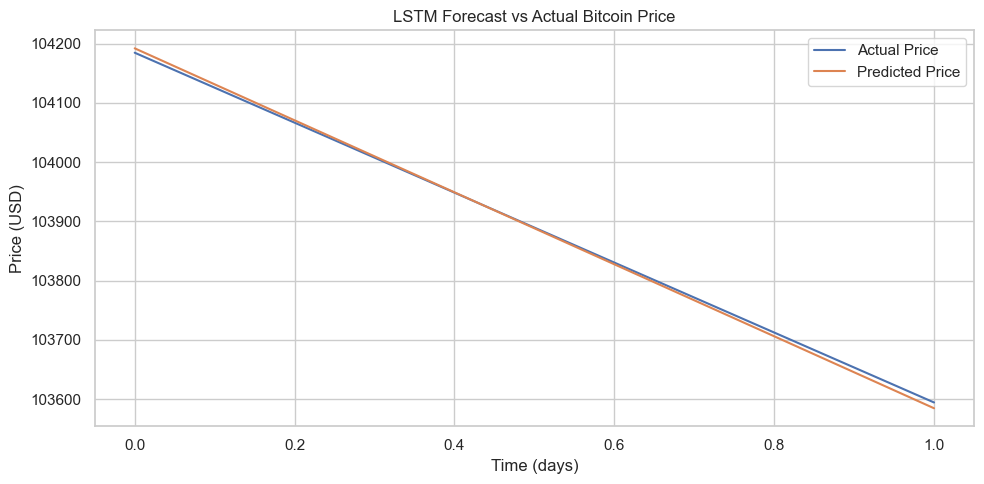

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("merged_data/sentiment_price_data.csv")
df = df[['Positive', 'Neutral', 'Negative', 'price']]

# Normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

#Create LSTM input sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, -1])  # target is next-day price
    return np.array(X), np.array(y)

seq_length = 5  # Use past 5 days to predict next
X, y = create_sequences(scaled, seq_length)

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train
history = model.fit(X, y, epochs=100, batch_size=8, verbose=0)

# Predict on training data
predicted = model.predict(X)

# Inverse scale predictions
price_index = -1  # 'price' is last column
predicted_prices = scaler.inverse_transform(np.concatenate(
    [np.zeros((len(predicted), df.shape[1]-1)), predicted], axis=1))[:, price_index]

actual_prices = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y), df.shape[1]-1)), y.reshape(-1, 1)], axis=1)
)[:, price_index]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.title("LSTM Forecast vs Actual Bitcoin Price")
plt.xlabel("Time (days)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### LSTM (Long Short Term Memory)

#### 1. Data Prep

(i) Used merged_data/sentiment_price_data.csv containing: Positive, Neutral, Negative sentiment percentages

(ii) Actual Bitcoin price

(iii) Normalized the data using MinMaxScaler

(iv) Created sequences of past 5 days to predict the next day’s price

#### 2. Model Training
(i) Built a Sequential LSTM model: LSTM → Dense ReLU → Dense output

(ii) Trained it over 100 epochs

(iii) Predicted next-day Bitcoin prices based on sentiment + past prices

#### 3. Visualization: 
(i) Plotted predicted vs actual prices on the same chart

(ii) Validated visually whether the model is learning useful patterns